In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [6]:
print("Loading LFW dataset...")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Get the image data and labels
X = lfw_people.data
y = lfw_people.target
n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f"Dataset loaded successfully!")
print(f"Total samples: {n_samples}")
print(f"Image dimensions: {h}x{w}")
print(f"Number of unique people (classes): {n_classes}\n")

X = X.reshape(n_samples, h, w, 1).astype('float32') / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}\n")

def create_pairs(x, digit_indices, num_classes):
    pairs = []
    labels = []
    
    for d in range(num_classes):
        indices_d = np.where(digit_indices == d)[0]
        for i in range(len(indices_d)):
            for j in range(i + 1, len(indices_d)):
                z1, z2 = indices_d[i], indices_d[j]
                pairs += [[x[z1], x[z2]]]
                
                inc = np.random.randint(1, num_classes)
                dn = (d + inc) % num_classes
                indices_dn = np.where(digit_indices == dn)[0]
                z2_neg = indices_dn[np.random.randint(0, len(indices_dn))]
                pairs += [[x[z1], x[z2_neg]]]
                
                labels += [1, 0] 
                
    return np.array(pairs), np.array(labels)


train_pairs, train_y = create_pairs(X_train, y_train, n_classes)


test_pairs, test_y = create_pairs(X_test, y_test, n_classes)

print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of testing pairs: {len(test_pairs)}")
print(f"Shape of a single pair: {train_pairs[0].shape}")
print(f"Example labels: {train_y[:10]}\n") 








Loading LFW dataset...
Dataset loaded successfully!
Total samples: 1288
Image dimensions: 50x37
Number of unique people (classes): 7

Training samples: 966
Testing samples: 322

Number of training pairs: 212254
Number of testing pairs: 27638
Shape of a single pair: (2, 50, 37, 1)
Example labels: [1 0 1 0 1 0 1 0 1 0]



In [7]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (5, 5), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

input_shape = (h, w, 1)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_model = Model([input_a, input_b], distance)

siamese_model.compile(loss=contrastive_loss, optimizer=Adam(0.0001), metrics=['accuracy'])

print("Siamese Network Architecture:")
siamese_model.summary()


Siamese Network Architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50, 37, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 50, 37, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 128)       │    592,896 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 592,896 (2.26 MB)

 Trainable params: 592,896 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
print("\nTraining the Siamese Network...")
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], 
    train_y,                                
    batch_size=128,
    epochs=5,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y)
)
print("Training finished.")



Training the Siamese Network...
Epoch 1/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 461s 276ms/step - accuracy: 0.4599 - loss: 0.3155 - val_accuracy: 0.3403 - val_loss: 0.2141
Epoch 2/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 425s 256ms/step - accuracy: 0.2713 - loss: 0.1865 - val_accuracy: 0.2645 - val_loss: 0.1854
Epoch 3/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 411s 248ms/step - accuracy: 0.1893 - loss: 0.1484 - val_accuracy: 0.2290 - val_loss: 0.1682
Epoch 4/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 420s 253ms/step - accuracy: 0.1447 - loss: 0.1247 - val_accuracy: 0.2063 - val_loss: 0.1589
Epoch 5/5
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 410s 247ms/step - accuracy: 0.1129 - loss: 0.1062 - val_accuracy: 0.1871 - val_loss: 0.1522
Training finished.


864/864 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step

Test Accuracy: 0.8129

Visualizing some test predictions...


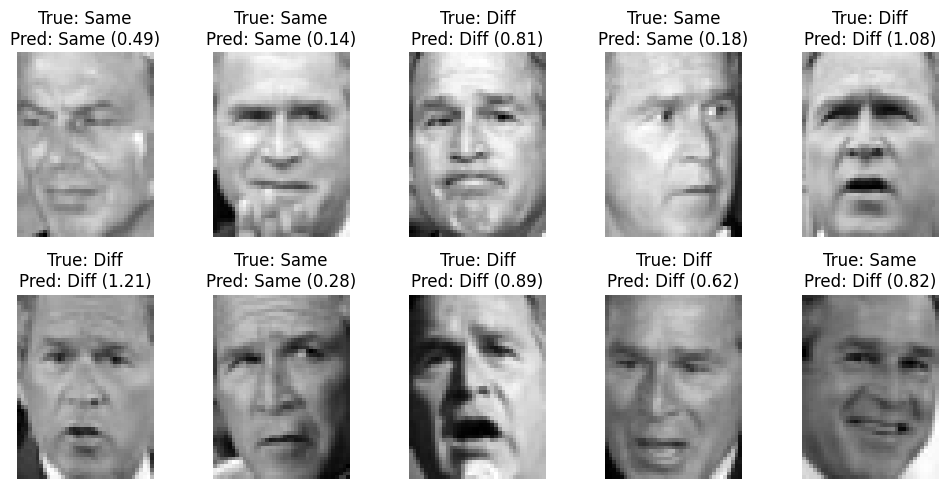

In [9]:
def compute_accuracy(y_true, y_pred, threshold=0.5):
    """
    Compute classification accuracy with a fixed threshold on distances.
    If distance < threshold, predict same person (1). Otherwise, different (0).
    """
    return np.mean((y_pred.ravel() < threshold) == y_true)

y_pred_test = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])

test_accuracy = compute_accuracy(test_y, y_pred_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

def visualize_predictions(pairs, labels, predictions, num_to_show=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_to_show):
        idx = np.random.choice(len(pairs))
        
        img1, img2 = pairs[idx][0], pairs[idx][1]
        true_label = labels[idx]
        pred_dist = predictions[idx][0]
        
        pred_label = 1 if pred_dist < 0.5 else 0

        ax = plt.subplot(2, num_to_show // 2, i + 1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title(f"True: {'Same' if true_label == 1 else 'Diff'}\nPred: {'Same' if pred_label == 1 else 'Diff'} ({pred_dist:.2f})")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

print("\nVisualizing some test predictions...")
visualize_predictions(test_pairs, test_y, y_pred_test)